# Convergence

Description of the UCI protocol: https://ucichessengine.wordpress.com/2011/03/16/description-of-uci-protocol/

Let us parse the logs first:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
! grep "multipv 1" log8c.txt  | grep -v lowerbound | grep -v upperbound > log8c_g.txt

In [3]:
def parse_info(l):
    D = {}
    k = l.split()
    i = 0
    assert k[i] == "info"
    i += 1
    while i < len(k):
        if k[i] == "depth":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "seldepth":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "multipv":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "score":
            if k[i+1] == "cp":
                D["score_p"] = int(k[i+2]) / 100. # score in pawns
            i += 3
        elif k[i] == "nodes":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "nps":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "hashfull":
            D[k[i]] = int(k[i+1]) / 1000. # between 0 and 1
            i += 2
        elif k[i] == "tbhits":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "time":
            D[k[i]] = int(k[i+1]) / 1000. # elapsed time in [s]
            i += 2
        elif k[i] == "pv":
            D[k[i]] = k[i+1:]
            return D
        else:
            raise Exception("Unknown kw")

In [4]:
# Convert to an array of lists
D = []
for l in open("log8c_g.txt").readlines():
    D.append(parse_info(l))

# Convert to a list of arrays
data = {}
for key in D[-1].keys():
    d = []
    for x in D:
        if key in x:
            d.append(x[key])
        else:
            d.append(-1)
    if key != "pv":
        d = array(d)
    data[key] = d

## The Speed of Search

The number of nodes searched depend linearly on time:

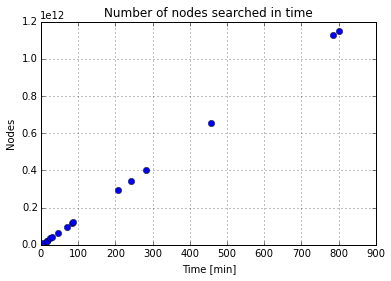

In [5]:
title("Number of nodes searched in time")
plot(data["time"] / 60., data["nodes"], "o")
xlabel("Time [min]")
ylabel("Nodes")
grid()
show()

So nodes per second is roughly constant:

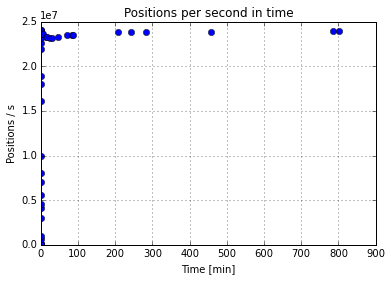

In [6]:
title("Positions per second in time")
plot(data["time"] / 60., data["nps"], "o")
xlabel("Time [min]")
ylabel("Positions / s")
grid()
show()

The hashtable usage is at full capacity:

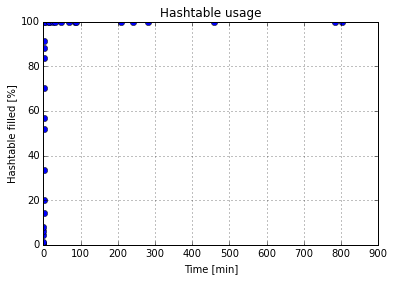

In [7]:
title("Hashtable usage")
hashfull = data["hashfull"]
hashfull[hashfull == -1] = 0
plot(data["time"] / 60., hashfull * 100, "o")
xlabel("Time [min]")
ylabel("Hashtable filled [%]")
grid()
show()

Number of nodes needed for the given depth grows exponentially, except for moves that are forced, which require very little nodes to search (those show as a horizontal plateau):

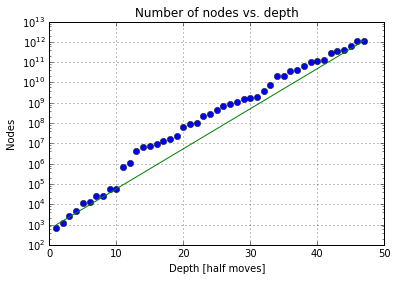

In [8]:
title("Number of nodes vs. depth")
semilogy(data["depth"], data["nodes"], "o")
x = data["depth"]
y = exp(x/2.2)
y = y / y[-1] * data["nodes"][-1]
semilogy(x, y, "-")
xlabel("Depth [half moves]")
ylabel("Nodes")
grid()
show()

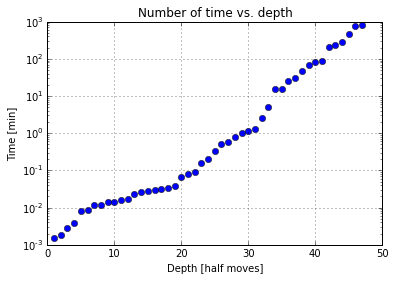

In [9]:
title("Number of time vs. depth")
semilogy(data["depth"], data["time"]/60., "o")
xlabel("Depth [half moves]")
ylabel("Time [min]")
grid()
show()

## Convergence wrt. Depth

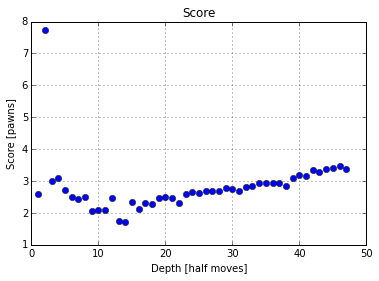

In [10]:
title("Score")
plot(data["depth"], data["score_p"], "o")
xlabel("Depth [half moves]")
ylabel("Score [pawns]")
grid()
show()

Convergence of the variations:

In [11]:
for i in range(len(data["depth"])):
    print "%2i %s" % (data["depth"][i], " ".join(data["pv"][i])[:100])

 1 e7g6
 2 e7g6 a2a3 d8h4
 3 f8g8 a2a3 f7f8
 4 f8g8 e2h5 f7f8 g2g3 e7d5
 5 f8g8 a1e1 f7f8 e2h5 c8d7
 6 f8g8 e2h5 f7f8 a1e1 c8d7 h4b4 b7b6
 7 f8g8 a1e1 f7f8 e2h5 a7a5 h4d4 c8d7
 8 f8g8 a1e1 f7f8 e2h5 a7a5 h4d4 c8d7 h2h4
 9 f8g8 e2h5 f7f8 a1e1 c8d7 h4d4 d7e8 d4b4 e8h5 h7h5
10 f8g8 e2h5 f7f8 h4d4 a7a5 a1e1 a5a4 d4d3 c8d7 f2f4 a4a3 b2a3 d7e8
11 f8g8 a1e1 f7f8 e2f3 c8d7 h4b4 b7b6 b4b3 d7e8 b3e3 e8g6 h7h4
12 f8g8 e2f3 f7f6 h4h3 c8d7 h3g3 f6f7 a1e1 f7f8 h7h4 d7e8 h4b4 e8f7 g3g5 a8b8
13 f8g8 h4h6 f7f8 e2h5 e7d5 a1e1 c8d7 h5f3 d5e7 f3h5 d7e8 h6e6 e8h5 h7h5 d8e8 h5f3
14 f8g8 h4h6 f7f8 e2h5 e7d5 a1e1 c8d7 h5f3 d5e7 f3h5 g7g6 a2a3 d6d5 h5g6 e7g6 h6g6 g8g6
15 f8g8 h4h3 f7f8 e2c4 c8d7 a1e1 b7b5 c4b3 a7a5 a2a3 a5a4 b3a2 e7c8 h7g6 d8f6 g6f6 g7f6 e1c1 f5f4 h3c3 
16 f8g8 a1e1 c8d7 h4h6 f7f8 e2h5 e7d5 h5f3 d5e7 f3h5 g7g6 h5g6 g8g7 h7h8 e7g8 h2h4 d8f6 h4h5 d7e8 h6h7
17 f8g8 h4h3 f7f8 e2c4 c8d7 a1e1 b7b5 c4b3 a7a5 h3f3 a5a4 b3c2 b5b4 a2a3 b4a3 f3a3 d8e8 a3c3 e8f7 c3c7 
18 f8g8 h4h3 f7f8 e2c4 c8d7 a1e1 b7b5